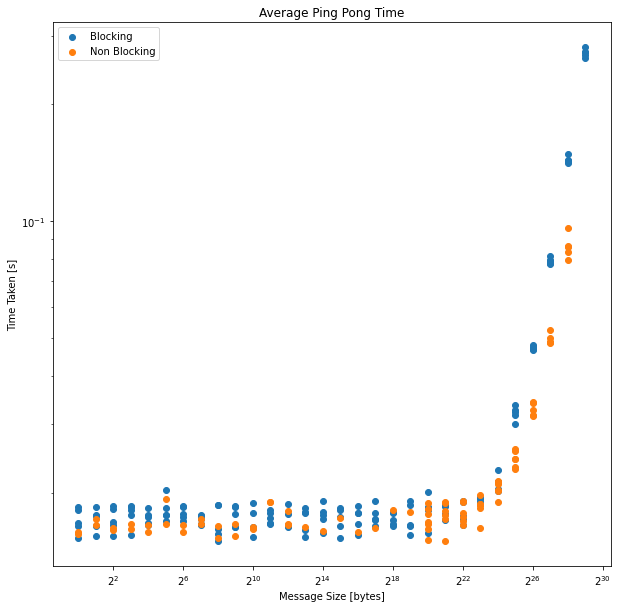

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns 
import subprocess
import pandas as pd
import numpy as np

header = ['Processors', 'Message Size', 'Time Taken']
################################################################
#Blocking Data
data_b = pd.read_csv('ping_pong_blocking.csv', header=0)
data_b.columns = header
data_b.head()

processors_b = data_b['Processors']
messageSize_b = data_b['Message Size']
time_b = data_b['Time Taken']
iterations = 100

avgCommunicationTime_b = time_b / iterations

################################################################
#non- blocking Data
data_nb = pd.read_csv('ping_pong_nonblocking.csv', header=0)
data_nb.columns = header
data_nb.head()

processors_nb = data_nb['Processors']
messageSize_nb = data_nb['Message Size']
time_nb = data_nb['Time Taken']
iterations = 100

avgCommunicationTime_nb = time_nb / iterations
################################################################

plt.figure(figsize=(10,10))
plt.scatter(messageSize_b, avgCommunicationTime_b,label = 'Blocking')
plt.scatter(messageSize_nb,avgCommunicationTime_nb,label = 'Non Blocking')
plt.xscale('log', base=2)
plt.yscale('log')
plt.title('Average Ping Pong Time')
plt.xlabel('Message Size [bytes]')
plt.ylabel('Time Taken [s]')
plt.legend()
plt.savefig('PingPong.png')
plt.show()

Slope for Blocking =  0.7771507429724145
Approximate Bandwidth for Ping Pong Blocking:  0.5835180776317543
Slope for Non-Blocking =  0.5997510375078775
Approximate Bandwidth for Ping Pong Non-Blocking:  0.6598678173999306


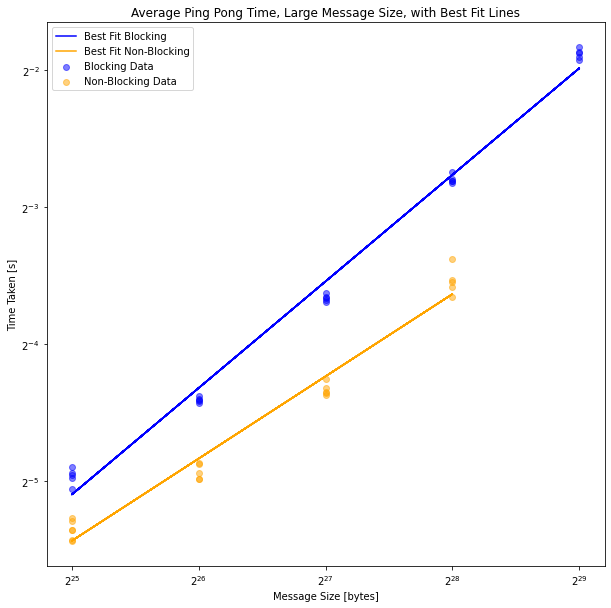

In [15]:
# Approximate Latency
def approximate_bandwidth(data, color, label):
    # Filtering the data for high message sizes
    high_data = data[data['Message Size'] >= 2**25]
    
    # Compute average communication time (assuming 100 iterations for average)
    avgCommunicationTime = high_data['Time Taken'] / 100

    # Logarithmic transformation of message sizes and time taken
    log_messageSize = np.log2(high_data['Message Size'])
    log_avgCommunicationTime = np.log2(avgCommunicationTime)
    
    # Fit a linear model
    model = LinearRegression()
    model.fit(log_messageSize.values.reshape(-1, 1), log_avgCommunicationTime.values.reshape(-1, 1))

    # Predicting the best fit line
    best_fit = model.predict(log_messageSize.values.reshape(-1, 1))

    # Output the slope and approximate bandwidth
    slope = model.coef_[0, 0]
    bandwidth = 1 / 2**slope
    print(f'Slope for {label} = ', slope)
    print(f'Approximate Bandwidth for Ping Pong {label}: ', bandwidth)

    # Plotting the scatter data and best fit line
    plt.scatter(high_data['Message Size'], avgCommunicationTime, color=color, alpha=0.5, label=f'{label} Data')
    plt.plot(high_data['Message Size'], 2**best_fit.flatten(), color=color, label=f'Best Fit {label}')

plt.figure(figsize=(10, 10))
approximate_bandwidth(data_b, 'blue', 'Blocking')
approximate_bandwidth(data_nb, 'orange', 'Non-Blocking')

plt.xscale('log', base=2)
plt.yscale('log', base=2)
plt.title('Average Ping Pong Time, Large Message Size, with Best Fit Lines')
plt.xlabel('Message Size [bytes]')
plt.ylabel('Time Taken [s]')
plt.legend()
plt.savefig('PingPongBandwidth.png')

plt.show()

/opt/software/Python/3.6.4-foss-2018a/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:480: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([0.00043454, 0.00049948]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 35, 'nit': 7, 'warnflag': 2}
  ConvergenceWarning)
/opt/software/Python/3.6.4-foss-2018a/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:357: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/opt/software/Python/3.6.4-foss-2018a/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:357: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


Latency Prediction =  1.729923057936972
Latency Prediction =  1.6430407723897495


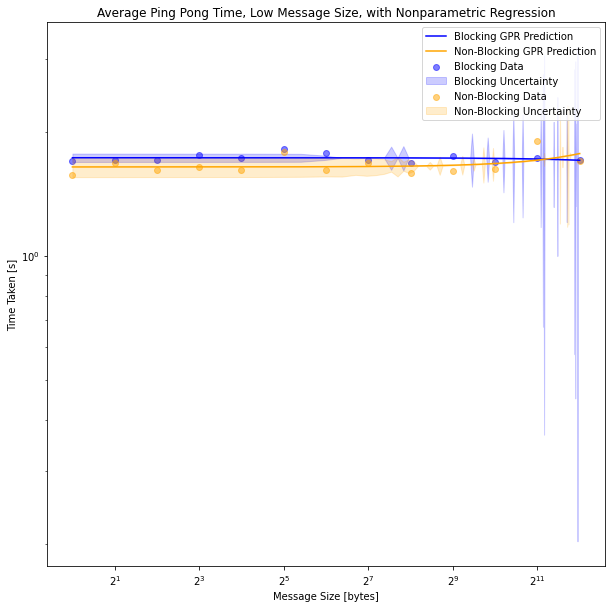

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel

def latency_ping_pong(data, color, label):
    message_sizes = data['Message Size'].unique()
    avg_times = data.groupby('Message Size')['Time Taken'].mean()

    low_message_size_data = data[data['Message Size'] <= 4096]
    low_message_sizes = low_message_size_data['Message Size'].unique()
    low_avg_times = low_message_size_data.groupby('Message Size')['Time Taken'].mean()

    kernel = DotProduct() + WhiteKernel()
    gpr = GaussianProcessRegressor(kernel=kernel, alpha=1e-10, random_state=0)
    gpr.fit(low_message_sizes.reshape(-1, 1), low_avg_times)
    message_size_plot = np.linspace(min(low_message_sizes), max(low_message_sizes), 200).reshape(-1, 1)
    gpr_pred, gpr_sigma = gpr.predict(message_size_plot, return_std=True)

    latency_pred = gpr.predict([[0]])[0]
    print('Latency Prediction = ', latency_pred)

    # Plot the actual data points
    plt.scatter(low_message_sizes, low_avg_times, color=color, alpha=0.5, label=f'{label} Data')
    # Plot the Gaussian Process Regression prediction
    plt.plot(message_size_plot, gpr_pred, color=color, label=f'{label} GPR Prediction')
    # Plot uncertainty bounds as a shaded region
    plt.fill_between(message_size_plot.flatten(), gpr_pred - gpr_sigma, gpr_pred + gpr_sigma, color=color, alpha=0.2, label=f'{label} Uncertainty')

plt.figure(figsize=(10, 10))
latency_ping_pong(data_b, 'blue', 'Blocking')
latency_ping_pong(data_nb, 'orange', 'Non-Blocking')

plt.title('Average Ping Pong Time, Low Message Size, with Nonparametric Regression')
plt.xlabel('Message Size [bytes]')
plt.ylabel('Time Taken [s]')
plt.xscale('log', base=2)
plt.yscale('log')
plt.legend()
plt.savefig('PingPongLatency.png')

plt.show()

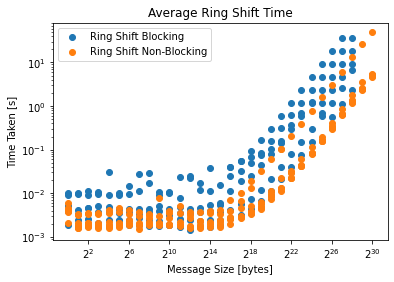

In [16]:
header = ['Processors', 'Message Size', 'Time Taken']
################################################################
# Ring Shift Blocking Data
data_rs_b = pd.read_csv('ring_shift_blocking.csv', header=0)
data_rs_b.columns = header

processors_rs_b = data_rs_b['Processors']
messageSize_rs_b = data_rs_b['Message Size']
time_rs_b = data_rs_b['Time Taken']
iterations = 100

avgCommunicationTime_rs_b = time_rs_b / iterations

################################################################
# Ring Shift Non-Blocking Data
data_rs_nb = pd.read_csv('ring_shift_nonblocking.csv', header=0)
data_rs_nb.columns = header

processors_rs_nb = data_rs_nb['Processors']
messageSize_rs_nb = data_rs_nb['Message Size']
time_rs_nb = data_rs_nb['Time Taken']

avgCommunicationTime_rs_nb = time_rs_nb / iterations
################################################################

plt.figure()
plt.scatter(messageSize_rs_b, avgCommunicationTime_rs_b, label='Ring Shift Blocking')
plt.scatter(messageSize_rs_nb, avgCommunicationTime_rs_nb, label='Ring Shift Non-Blocking')
plt.xscale('log', base=2)
plt.yscale('log')
plt.title('Average Ring Shift Time')
plt.xlabel('Message Size [bytes]')
plt.ylabel('Time Taken [s]')
plt.legend()
plt.savefig('AverageRingShiftTime.png')

plt.show()


Slope for Blocking =  0.8236670935494553
Approximate Bandwidth for Ping Pong Blocking:  0.5650039686993044
Slope for Non-Blocking =  0.9867006748686004
Approximate Bandwidth for Ping Pong Non-Blocking:  0.5046305049676336


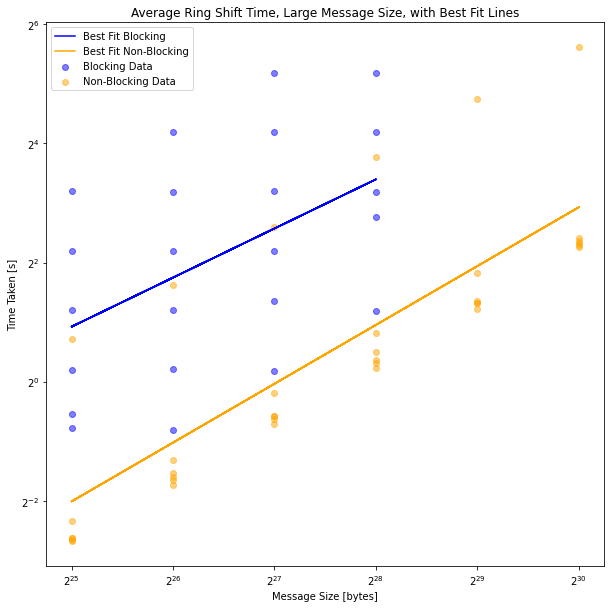

In [20]:
plt.figure(figsize=(10, 10))
approximate_bandwidth(data_rs_b, 'blue', 'Blocking')
approximate_bandwidth(data_rs_nb, 'orange', 'Non-Blocking')

plt.xscale('log', base=2)
plt.yscale('log', base=2)
plt.title('Average Ring Shift Time, Large Message Size, with Best Fit Lines')
plt.xlabel('Message Size [bytes]')
plt.ylabel('Time Taken [s]')
plt.legend()
plt.savefig('RingShiftBandwidth.png')

plt.show()

/opt/software/Python/3.6.4-foss-2018a/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:357: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/opt/software/Python/3.6.4-foss-2018a/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:357: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


Latency Prediction =  0.6328572964072512
Latency Prediction =  0.2698238677307304


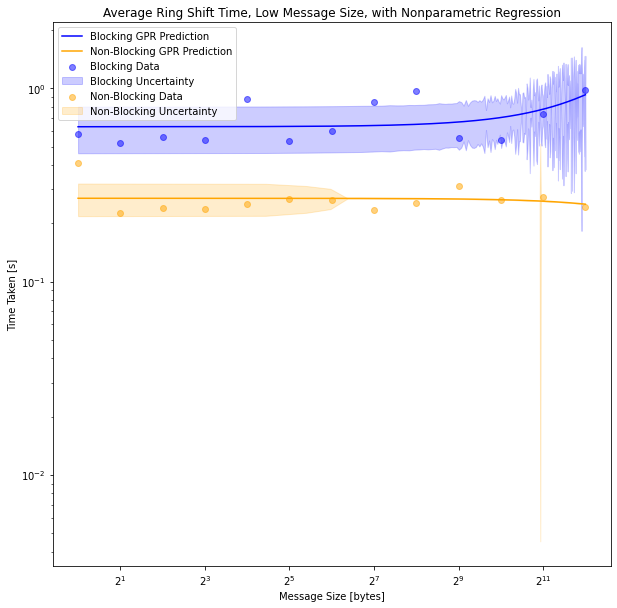

In [19]:
plt.figure(figsize=(10, 10))
latency_ping_pong(data_rs_b, 'blue', 'Blocking')
latency_ping_pong(data_rs_nb, 'orange', 'Non-Blocking')

plt.title('Average Ring Shift Time, Low Message Size, with Nonparametric Regression')
plt.xlabel('Message Size [bytes]')
plt.ylabel('Time Taken [s]')
plt.xscale('log', base=2)
plt.yscale('log')
plt.legend()
plt.savefig('RingShiftLatency.png')

plt.show()